# ÎÖ∏Îìú Ï†úÍ≥µ Í∏∞Î≥∏ Î™®Îç∏

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
# Îç∞Ïù¥ÌÑ∞ Î°úÎìúÌï† Îïå Îπ†Î•¥Í≤å Î°úÎìúÌï† Ïàò ÏûàÎèÑÎ°ùÌïòÎäî ÏÑ§Ï†ï Î≥ÄÏàò
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY Ïù¥ÎØ∏ÏßÄ ÏÇ¨Ïù¥Ï¶à Î≥ÄÏàò
IMAGE_SIZE = [180, 180]

# Îç∞Ïù¥ÌÑ∞ Í≤ΩÎ°ú Î≥ÄÏàò
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *ÏùÄ Î™®Îì† ÎîîÎ†âÌÜ†Î¶¨ÏôÄ ÌååÏùºÏùÑ ÏùòÎØ∏Ìï©ÎãàÎã§.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

print(ROOT_PATH)

/aiffel/aiffel


In [3]:
# ÌîÑÎ°úÏ†ùÌä∏Î•º ÏßÑÌñâÌï† Îïå ÏïÑÎûò Îëê Î≥ÄÏàòÎ•º Î≥ÄÍ≤ΩÌï¥Î≥¥ÏÑ∏Ïöî
BATCH_SIZE = 16
EPOCHS = 10


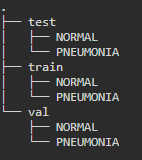

In [4]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [5]:
# train Îç∞Ïù¥ÌÑ∞ÏôÄ validation Îç∞Ïù¥ÌÑ∞Î•º Î™®Îëê filenamesÏóê Îã¥ÏäµÎãàÎã§
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# Î™®ÏïÑÏßÑ filenamesÎ•º 8:2Î°ú ÎÇòÎàïÎãàÎã§
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [6]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

# Ï≤òÏùå 10Í∞úÏùò ÌååÏùº Í≤ΩÎ°úÎßå Ï∂úÎ†•
print("Shuffled filenames:\n" + "\n".join(filenames[:10]))

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg
Shuffled filenames:
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1026_bacteria_2957.jpeg
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person426_bacteria_1863.jpeg
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1361_virus_2344.jpeg
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0291-0001.jpeg
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person805_bacteria_2712.jpeg
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0566-0001.jpeg
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1317_bacteria_3332.jpeg
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1002-0001.jpeg
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0519-0001-0001.jpeg


In [7]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [8]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [9]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [10]:
# ÌååÏùº Í≤ΩÎ°úÏùò ÎÅùÏóêÏÑú ÎëêÎ≤àÏß∏ Î∂ÄÎ∂ÑÏùÑ ÌôïÏù∏ÌïòÎ©¥ ÏñëÏÑ±Í≥º ÏùåÏÑ±ÏùÑ Íµ¨Î∂ÑÌï† Ïàò ÏûàÏäµÎãàÎã§
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # ÌèêÎ†¥Ïù¥Î©¥ ÏñëÏÑ±(True), ÎÖ∏ÎßêÏù¥Î©¥ ÏùåÏÑ±(False)

In [11]:
# Ïù¥ÎØ∏ÏßÄÎ•º ÏïåÎßûÏùÄ ÌòïÏãùÏúºÎ°ú Î∞îÍøâÎãàÎã§.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # Ïù¥ÎØ∏ÏßÄÎ•º uint8 tensorÎ°ú ÏàòÏ†ï
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 ÌÉÄÏûÖÏúºÎ°ú ÏàòÏ†ï
    img = tf.image.resize(img, IMAGE_SIZE) # Ïù¥ÎØ∏ÏßÄ ÏÇ¨Ïù¥Ï¶àÎ•º IMAGE_SIZEÎ°ú ÏàòÏ†ï
    return img

# Ïù¥ÎØ∏ÏßÄ ÌååÏùºÏùò Í≤ΩÎ°úÎ•º ÏûÖÎ†•ÌïòÎ©¥ Ïù¥ÎØ∏ÏßÄÏôÄ ÎùºÎ≤®ÏùÑ ÏùΩÏñ¥ÏòµÎãàÎã§.
def process_path(file_path):
    label = get_label(file_path) # ÎùºÎ≤® Í≤ÄÏ∂ú
    img = tf.io.read_file(file_path) # Ïù¥ÎØ∏ÏßÄ ÏùΩÍ∏∞
    img = decode_img(img) # Ïù¥ÎØ∏ÏßÄÎ•º ÏïåÎßûÏùÄ ÌòïÏãùÏúºÎ°ú ÏàòÏ†ï
    return img, label

In [12]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [14]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    # print(label)  # tf.Tensor(False, shape=(), dtype=bool)

Image shape:  (180, 180, 3)
Label:  False


In [15]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [16]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    # Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ Î¨¥ÏûëÏúÑÎ°ú ÏÑûÏñ¥ÏÑú Îç∞Ïù¥ÌÑ∞ ÏàúÏÑúÏùò ÏòÅÌñ•ÏùÑ Î∞õÏßÄ ÏïäÎèÑÎ°ù Ìï®
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # ÏóêÌè¨ÌÅ¨Í∞Ä ÎÅùÎÇòÎèÑ Îç∞Ïù¥ÌÑ∞ÏÖãÏù¥ Í≥ÑÏÜç Î∞òÎ≥µÎêòÎèÑÎ°ù ÏÑ§Ï†ï (Î¨¥Ìïú Î∞òÎ≥µ)
    ds = ds.repeat()
    # Î∞∞Ïπò Îã®ÏúÑÎ°ú Îç∞Ïù¥ÌÑ∞Î•º Î¨∂Ïùå (Ïó¨Í∏∞ÏÑúÎäî BATCH_SIZEÎ°ú ÏßÄÏ†ïÎêú ÌÅ¨Í∏∞ÎßåÌÅº Î¨∂Ïùå)
    ds = ds.batch(BATCH_SIZE)
    # Îç∞Ïù¥ÌÑ∞Î•º ÎØ∏Î¶¨ Î°úÎìúÌïòÏó¨ ÌïôÏäµ Ï§ëÏóê GPU/CPUÍ∞Ä Îç∞Ïù¥ÌÑ∞Î•º Í∏∞Îã§Î¶¨ÏßÄ ÏïäÎèÑÎ°ù Ìï®
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

# ÌïôÏäµÏö© Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ Ï§ÄÎπÑ
train_ds = prepare_for_training(train_ds)
# Í≤ÄÏ¶ùÏö© Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ Ï§ÄÎπÑ
val_ds = prepare_for_training(val_ds)


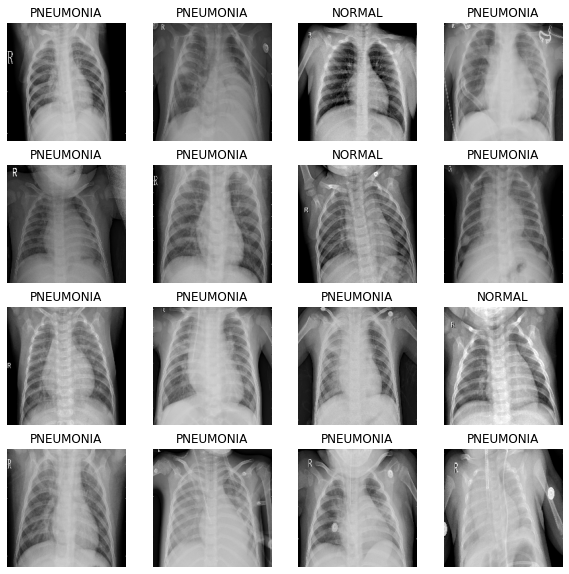

In [18]:
# Ïù¥ÎØ∏ÏßÄ Î∞∞ÏπòÎ•º ÏûÖÎ†•Î∞õÏïÑ Ïó¨Îü¨ Ïû•Ïùò Ïù¥ÎØ∏ÏßÄÎ•º Ìïú ÌôîÎ©¥Ïóê ÏãúÍ∞ÅÌôîÌïòÎäî Ìï®Ïàò
def show_batch(image_batch, label_batch):
    # 10x10 ÌÅ¨Í∏∞Ïùò Îπà Í∑∏Î¶º(figure)ÏùÑ ÏÉùÏÑ±
    plt.figure(figsize=(10,10))
    
    # BATCH_SIZEÎßåÌÅº Î∞òÎ≥µÌïòÎ©¥ÏÑú Ïù¥ÎØ∏ÏßÄÏôÄ ÎùºÎ≤®ÏùÑ Í∞ÅÍ∞Å subplotÏóê Í∑∏Î†§Ï§å
    for n in range(BATCH_SIZE):
        # 4Ìñâ, (BATCH_SIZE/4)Ïó¥Ïùò gridÏóêÏÑú n+1Î≤àÏß∏ subplotÏùÑ ÏÉùÏÑ±
        ax = plt.subplot(4, math.ceil(BATCH_SIZE/4), n+1)
        
        # Í∞Å Î∞∞ÏπòÏùò Ïù¥ÎØ∏ÏßÄÎ•º subplotÏóê Í∑∏Î†§Ï§å
        plt.imshow(image_batch[n])
        
        # ÎùºÎ≤®Ïù¥ 1Ïù¥Î©¥ ÌèêÎ†¥(PNEUMONIA), 0Ïù¥Î©¥ Ï†ïÏÉÅ(NORMAL)ÏúºÎ°ú ÌÉÄÏù¥ÌãÄ ÏÑ§Ï†ï
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        
        # Ï∂ïÏùÑ Ï†úÍ±∞Ìï¥ÏÑú Ïù¥ÎØ∏ÏßÄÎßå ÌëúÏãú
        plt.axis("off")


# train_dsÏóêÏÑú Ï≤´ Î≤àÏß∏ Î∞∞Ïπò Îç∞Ïù¥ÌÑ∞Î•º Í∞ÄÏ†∏Ïò¥ (Ïù¥ÎØ∏ÏßÄ Î∞∞ÏπòÏôÄ ÎùºÎ≤® Î∞∞Ïπò)
image_batch, label_batch = next(iter(train_ds))

# Ïù¥ÎØ∏ÏßÄÏôÄ ÎùºÎ≤®ÏùÑ ÎÑòÍ≤®Ï£ºÏñ¥ Î∞∞Ïπò ÎÇ¥ Ïù¥ÎØ∏ÏßÄÎ•º ÏãúÍ∞ÅÌôî
show_batch(image_batch.numpy(), label_batch.numpy())


In [20]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        # Batch Normalization Î†àÏù¥Ïñ¥: Í∞Å Î∞∞ÏπòÏóêÏÑú ÏûÖÎ†•ÏùÑ Ï†ïÍ∑úÌôîÌïòÏó¨ ÌïôÏäµ ÏïàÏ†ïÏÑ±ÏùÑ ÎÜíÏù¥Í≥† Gradient Vanishing/Exploding Î¨∏Ï†úÎ•º Ìï¥Í≤∞Ìï®
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

### **SeparableConv2D vs Conv2D Í∞ÑÎã® ÎπÑÍµê**

|                      | **Conv2D**                          | **SeparableConv2D**                  |
|----------------------|-------------------------------------|--------------------------------------|
| **Ïó∞ÏÇ∞ Î∞©Ïãù**        | Î™®Îì† ÏûÖÎ†• Ï±ÑÎÑêÏóê ÎåÄÌï¥ ÎèôÏãúÏóê ÌïÑÌÑ∞ Ï†ÅÏö© | ÏûÖÎ†• Ï±ÑÎÑêÎ≥ÑÎ°ú Î®ºÏ†Ä Î∂ÑÎ¶¨ ÌõÑ 1x1 ÌïÑÌÑ∞Î°ú Í≤∞Ìï© |
| **Ïó∞ÏÇ∞Îüâ**           | Ïó∞ÏÇ∞ ÎπÑÏö©Ïù¥ ÌÅº                        | Ïó∞ÏÇ∞ÎüâÏù¥ Ï†ÅÏñ¥ Ìö®Ïú®Ï†Å                 |
| **Î™®Îç∏ ÌÅ¨Í∏∞**        | ÎπÑÍµêÏ†Å ÌÅº                            | Îçî ÏûëÏùÄ Î™®Îç∏ ÌÅ¨Í∏∞ Í∞ÄÎä•               |
| **ÏÜçÎèÑ**             | ÎäêÎ¶º                                | Îçî Îπ†Î¶Ñ                              |
| **ÏÑ±Îä•**             | Î≥µÏû°Ìïú Ìå®ÌÑ¥ ÌïôÏäµ ÏÑ±Îä•Ïù¥ Îõ∞Ïñ¥ÎÇ®          | Î≥µÏû°Ìïú Ìå®ÌÑ¥ ÌïôÏäµÏóêÏÑ† ÏÑ±Îä•Ïù¥ ÎÇÆÏùÑ Ïàò ÏûàÏùå |
| **Ï†ÅÏö© ÏòàÏãú**        | ÏùºÎ∞ò CNN Î™®Îç∏Îì§                      | MobileNet Îì± Í≤ΩÎüâ Î™®Îç∏Ïóê ÏÇ¨Ïö©         |

### **Ïû•Îã®Ï†ê ÎπÑÍµê**

|                      | **Conv2D**                          | **SeparableConv2D**                  |
|----------------------|-------------------------------------|--------------------------------------|
| **Ïû•Ï†ê**             | Îçî Î≥µÏû°Ìïú Ìå®ÌÑ¥ÏùÑ Ïûò ÌïôÏäµ             | Ïó∞ÏÇ∞ÎüâÏù¥ Ï†ÅÏñ¥ Ìö®Ïú®Ï†Å, Îπ†Î¶Ñ, Í≤ΩÎüâÌôî Í∞ÄÎä• |
| **Îã®Ï†ê**             | Ïó∞ÏÇ∞ÎüâÏù¥ ÎßéÍ≥† ÎäêÎ¶º, Î©îÎ™®Î¶¨ ÎßéÏù¥ ÏÇ¨Ïö©  | Î≥µÏû°Ìïú Ìå®ÌÑ¥ ÌïôÏäµ ÏÑ±Îä•Ïù¥ ÎÇÆÏùÑ Ïàò ÏûàÏùå    |

Ïù¥Î†áÍ≤å **Conv2D**Îäî Î≥µÏû°Ìïú Ìå®ÌÑ¥ ÌïôÏäµÏóê Ïú†Î¶¨ÌïòÏßÄÎßå,
**SeparableConv2D**Îäî Ïó∞ÏÇ∞ Ìö®Ïú®ÏÑ±ÏùÑ ÎÜíÏù¥Í≥† Í≤ΩÎüâÌôîÎêú Î™®Îç∏ ÏÑ§Í≥ÑÏóê Í∞ïÏ†êÏùÑ Í∞ÄÏßÑÎã§.

In [21]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        # ÏôÑÏ†Ñ Ïó∞Í≤∞Ï∏µ (units ÏàòÎßåÌÅº Îâ¥Îü∞ÏùÑ ÏÉùÏÑ±ÌïòÍ≥† ReLU ÌôúÏÑ±Ìôî Ìï®Ïàò Ï†ÅÏö©)
        tf.keras.layers.Dense(units, activation='relu'),  
        
        # Batch NormalizationÏùÑ ÌÜµÌï¥ ÌïôÏäµ ÏïàÏ†ïÏÑ± Î∞è ÏÜçÎèÑ Ìñ•ÏÉÅ
        tf.keras.layers.BatchNormalization(),
        
        # DropoutÏùÑ ÏÇ¨Ïö©ÌïòÏó¨ Í≥ºÏ†ÅÌï© Î∞©ÏßÄ
        tf.keras.layers.Dropout(dropout_rate)  
    ])
    
    return block

In [23]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [24]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


In [25]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [26]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 150s 395ms/step - loss: 0.3658 - accuracy: 0.8415 - precision: 0.9588 - recall: 0.8225 - val_loss: 0.7747 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 61s 233ms/step - loss: 0.2064 - accuracy: 0.9246 - precision: 0.9765 - recall: 0.9208 - val_loss: 1.3631 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 57s 220ms/step - loss: 0.2013 - accuracy: 0.9282 - precision: 0.9753 - recall: 0.9270 - val_loss: 0.1193 - val_accuracy: 0.9510 - val_precision: 0.9429 - val_recall: 0.9935
Epoch 4/10
261/261 [==============================] - 58s 224ms/step - loss: 0.1829 - accuracy: 0.9294 - precision: 0.9776 - recall: 0.9263 - val_loss: 0.3644 - val_accuracy: 0.8375 - val_precision: 0.8185 - val_recall: 1.0000
Epoch 5/10
261/261 [==============================] - 59s 227ms/step - loss: 0.1772 - accur

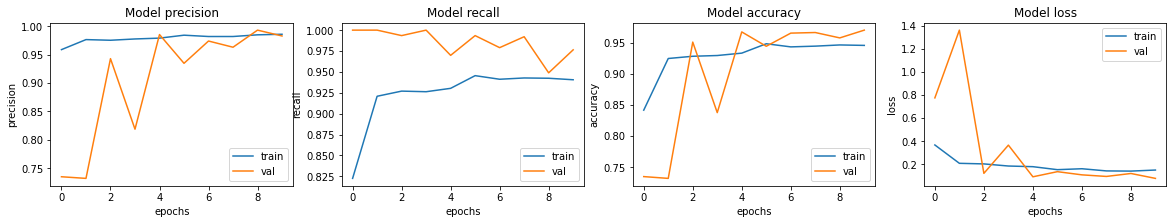

In [27]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [28]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 121ms/step - loss: 0.8542 - accuracy: 0.7708 - precision: 0.7352 - recall: 0.9897
Loss: 0.854248046875,
Accuracy: 0.7708333134651184,
Precision: 0.7352380752563477,
Recall: 0.9897435903549194


# ‚ö†Ô∏è ÌîÑÎ°úÏ†ùÌä∏: ÌèêÎ†¥ ÏßÑÎã®Í∏∞ ÏÑ±Îä•Í∞úÏÑ†

In [140]:
import tensorflow
from tensorflow import keras

print(tensorflow.__version__)

2.6.0


## Step 1. Ïã§ÌóòÌôòÍ≤Ω Set-up
Batch size, Epoch Îì±ÏùÑ Î≥ÄÍ≤Ω.

### üí° Í∏∞Î≥∏ Ï†úÍ≥µÎêú Î™®Îç∏ÏóêÏÑú Î≥ÄÍ≤Ω/Ï∂îÍ∞ÄÎêú Ï†ê
(Ïó¨Îü¨ Î™®Îç∏ ÎπÑÍµê Î™©Ï†ÅÏù¥ÎØÄÎ°ú, Í∞ÄÎèÖÏÑ± Ìñ•ÏÉÅÏùÑ ÏúÑÌï¥ model.fit Ïóê ÏßÅÏ†ë Í∏∞ÏûÖ)

## Step 2. Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑÌïòÍ∏∞
ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞Î•º Í∞ÄÏ†∏ÏôÄÏÑú Ï†ÑÏ≤òÎ¶¨ Î∞è Î∞∞Ïπò Íµ¨ÏÑ±ÏùÑ ÏßÑÌñâ.

### üí° Í∏∞Î≥∏ Ï†úÍ≥µÎêú Î™®Îç∏ÏóêÏÑú Î≥ÄÍ≤Ω/Ï∂îÍ∞ÄÎêú Ï†ê
- augment Ï∂îÍ∞Ä
    - Ï¢åÏö∞ Î∞òÏ†Ñ
        - Ï¢åÏö∞Í∞Ä Î∞òÏ†Ñ ÎêòÏñ¥ÎèÑ ÌèêÎ†¥ Ïó¨Î∂Ä ÌåêÎã®Ïóê ÏÜêÏÉÅ ÏóÜÏùÑ ÎìØ.
            - ÏÉÅÌïòÎ∞òÏ†ÑÏùÄ ÌïòÏßÄ ÏïäÏùå: ÏùºÎ∞òÏ†ÅÏúºÎ°ú ÏÉùÏÑ±Îê† Ïàò ÏóÜÎäî Ïù¥ÎØ∏ÏßÄÏù¥ÎØÄÎ°ú, Ïò§ÌûàÎ†§ ÌïôÏäµÏóê Î∂ÄÏ†ïÏ†ÅÏù∏ ÏòÅÌñ•ÏùÑ ÎØ∏Ïπ† Ïàò ÏûàÏñ¥ Î≥¥ÏûÑ.
    - Î∞ùÍ∏∞ Ï°∞Ï†ï, ÎåÄÎπÑ Ï°∞Ï†ï
        - ÎØ∏ÎØ∏Ìïú Î∞ùÍ∏∞/ÎåÄÎπÑ Î≥ÄÍ≤ΩÏùÄ ÌèêÎ†¥ Ïó¨Î∂Ä ÌåêÎã®Ïóê ÏßÄÏû• ÏóÜÏùÑ ÎìØ.
        - ÏÑ∏Î∂ÄÏ†ÅÏù∏ Ï∞®Ïù¥Î•º Îçî Ïûò ÌïôÏäµÌïòÏó¨ ÌèêÎ†¥ Ïó¨Î∂Ä ÌåêÎã®Ïóê ÎèÑÏõÄ Îê† ÎìØ.
        - Î≤îÏúÑÎ•º 5% ÎÇ¥Ïô∏Î°ú Ï°∞Ï†ïÌïòÏó¨ Ïù¥ÎØ∏ÏßÄÍ∞Ä ÌÅ¨Í≤å Î≥ÄÌòïÎêòÏßÄ ÏïäÎèÑÎ°ù Ìï®.
        - Ïä§ÏºÄÏùºÎßÅ
            - Î∞ùÍ∏∞/ÎåÄÎπÑ Ï°∞Ï†ï Î∞∞Ïú®Ïóê Îî∞Îùº Ïù¥ÎØ∏ÏßÄ Í∞íÏù¥ [0, 1] Î≤îÏúÑÎ•º Ï¥àÍ≥ºÌïòÎäî Í≤ΩÏö∞Í∞Ä Î∞úÏÉù.
            - GPTÎäî ÏûêÍæ∏Îßå tf.clip_by_value(image, 0.0, 1.0)ÏùÑ Ï∂îÏ≤úÌïòÏòÄÏúºÎÇò, Í∑∏Îü¨Î©¥ Ìå®ÌÑ¥Ïù¥ ÏÜêÏÉÅÎê† ÏúÑÌóòÏù¥ ÏûàÏùå.
            - Ìå®ÌÑ¥ÏùÑ Ïú†ÏßÄÌïòÍ∏∞ ÏúÑÌï¥ÏÑú ÏµúÎåÄ ÏöîÏÜåÍ∞Ä 1Î≥¥Îã§ ÌÅ¨Î©¥, Ìï¥Îãπ Í∞íÏúºÎ°ú ÎÇòÎà¥Ïùå.
        - clip_by_value
            - ÏúÑÏóêÏÑú Ïä§ÏºÄÏùºÎßÅÏùÑ ÌñàÏùåÏóêÎèÑ, Ïïå Ïàò ÏóÜÎäî Ïù¥Ïú†Î°ú ÏûêÍæ∏Îßå Í∞íÏù¥ Ï¥àÍ≥ºÎêòÏóàÎã§Îäî Í≤ΩÍ≥† Î©îÏãúÏßÄÍ∞Ä Îñ†ÏÑú Í∑∏ÎÉ• ÏßÅÏ†ë clip Ìï¥Ï§¨Ïùå. ÎÇòÏ§ëÏóê ÏõêÏù∏ ÌååÏïÖ ÌõÑ Ïû¨ Ïä§ÏºÄÏùºÎßÅ ÏãúÎèÑÌï† Í≤É.
            
- prepare_for_training Íµ¨Ï°∞ Î≥ÄÍ≤Ω
    - augment Î•º Ï∂îÍ∞ÄÌï®ÏúºÎ°úÏç®, ds.map ÌôúÏö©.
- input_shape Î≥ÄÏàò Ï∂îÍ∞Ä
    - Ï∂îÌõÑÏóê residual_block Îì±Ïùò Ìï®ÏàòÏóê ÌôúÏö©ÌïòÍ∏∞ ÏúÑÌï®.

In [141]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # ÎûúÎç§ÌïòÍ≤å Ï¢åÏö∞ Î∞òÏ†Ñ
    image = tf.image.random_brightness(image, max_delta=0.05)  # Î∞ùÍ∏∞ Ï°∞Ï†ï
    image = tf.image.random_contrast(image, lower=0.95, upper=1.05)  # ÎåÄÎπÑ Ï°∞Ï†ï
       
    # ÏµúÎåÄÍ∞í Í∏∞Ï§ÄÏúºÎ°ú Îã§Ïãú 0~1Î°ú Ïä§ÏºÄÏùºÎßÅ
    max_value = tf.reduce_max(image)
    if max_value > 1:
        image = image / max_value  # ÏµúÎåÄÍ∞íÏúºÎ°ú ÎÇòÎà†ÏÑú 0~1 ÏÇ¨Ïù¥Î°ú Îã§Ïãú Ïä§ÏºÄÏùºÎßÅ

    # Ïä§ÏºÄÏùºÎßÅ Ïù¥ÌõÑ Í∞íÏù¥ 0~1ÏùÑ Î≤óÏñ¥ÎÇòÏßÄ ÏïäÎèÑÎ°ù ÌÅ¥Î¶¨Ìïë
    image = tf.clip_by_value(image, 0.0, 1.0)


    return image, label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment Ï†ÅÏö© Î∂ÄÎ∂ÑÏù¥ Î∞∞ÏπòÏ≤òÎ¶¨ Ìï®ÏàòÏóê Ï∂îÍ∞ÄÎêòÏóàÏäµÎãàÎã§.
    ds = ds.map(
            augment,       # Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï Ï†ÅÏö©
            num_parallel_calls=2        
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

input_shape = 0
for image, label in train_ds.take(1):
    input_shape = image.numpy().shape
    print("Image shape: ", input_shape)
    print("Label: ", label.numpy())
    # print(label)  # tf.Tensor(False, shape=(), dtype=bool)


train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)


Image shape:  (180, 180, 3)
Label:  False


## Step 3. Îç∞Ïù¥ÌÑ∞ ÏãúÍ∞ÅÌôî
ÎßåÏïΩ augmentationÏùÑ ÏãúÎèÑÌñàÎã§Î©¥ Ïù¥ÌõÑ Ïã§Ïäµ ÏΩîÎìúÏóê ÏûàÎäî show_batch() Ìï®ÏàòÎ•º ÌÜµÌï¥ Ïã§Ï†úÎ°ú Ï¢åÏö∞ Î∞òÏ†Ñ Îì±Ïù¥ Ï†úÎåÄÎ°ú Ï≤òÎ¶¨ÎêòÏóàÎäîÏßÄ ÌôïÏù∏Ìï¥ Î¥ÖÏãúÎã§.

### üí° Í∏∞Î≥∏ Ï†úÍ≥µÎêú Î™®Îç∏ÏóêÏÑú Î≥ÄÍ≤Ω/Ï∂îÍ∞ÄÎêú Ï†ê
ÏóÜÏùå

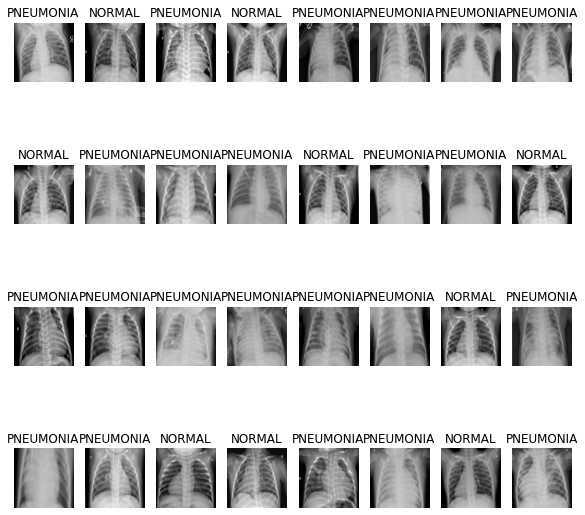

In [142]:
# train_dsÏóêÏÑú Ï≤´ Î≤àÏß∏ Î∞∞Ïπò Îç∞Ïù¥ÌÑ∞Î•º Í∞ÄÏ†∏Ïò¥ (Ïù¥ÎØ∏ÏßÄ Î∞∞ÏπòÏôÄ ÎùºÎ≤® Î∞∞Ïπò)
image_batch, label_batch = next(iter(train_ds))

# Ïù¥ÎØ∏ÏßÄÏôÄ ÎùºÎ≤®ÏùÑ ÎÑòÍ≤®Ï£ºÏñ¥ Î∞∞Ïπò ÎÇ¥ Ïù¥ÎØ∏ÏßÄÎ•º ÏãúÍ∞ÅÌôî
show_batch(image_batch.numpy(), label_batch.numpy())

## Step 4. ResNet-18 Íµ¨ÌòÑ
ÏùòÎ£å ÏòÅÏÉÅ ÌåêÎèÖÏùÑ ÏúÑÌï¥ Ïã§ÏäµÏóêÏÑú Íµ¨ÌòÑÌñàÎçò modelÏóêÏÑú Îã§ÏñëÌïú Í≤ÉÎì§ÏùÑ Î∞îÍæ∏Ïñ¥ Í∞ÄÎ©∞ Ïã§ÌóòÌï¥Î≥º Ïàò ÏûàÏäµÎãàÎã§. Convolution filter, Ï±ÑÎÑê Í∞úÏàò, activation, Î™®Îç∏ Íµ¨Ï°∞ Îì±ÏùÑ Îã§ÏñëÌïòÍ≤å Î∞îÍæ∏Ïñ¥Î≥º Ïàò ÏûàÏäµÎãàÎã§.

ResNetÏùÄ Residual blockÏùÑ Î®ºÏ†Ä Íµ¨ÏÑ±Ìï¥Ïïº Ìï©ÎãàÎã§. ResNetÏóêÏÑúÏùò weight layerÎäî

3x3 CNN
BatchNormalization
ÌôúÏÑ±Ìôî Ìï®Ïàò ReLU
Î°ú Íµ¨ÏÑ±ÎêòÏñ¥ ÏûàÏäµÎãàÎã§.

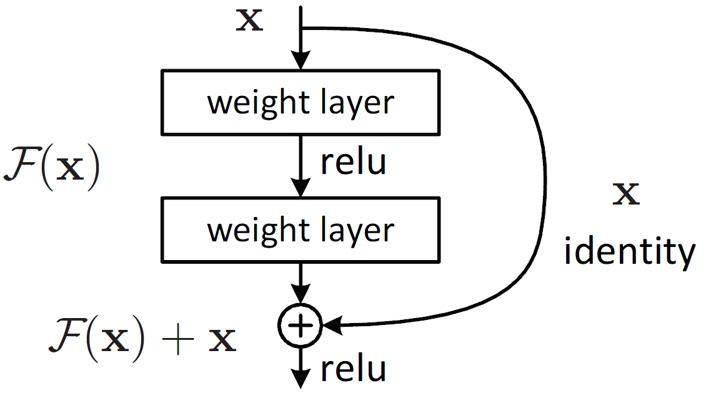

In [143]:
# ÎÖ∏ÎìúÏóêÏÑú Ï†úÍ≥µÌïú ÏÉòÌîå ÏΩîÎìú.
# ‚ö†Ô∏è Ï∞∏Í≥†Ïö©Ïù¥ÎØÄÎ°ú, ÏÇ¨Ïö©ÌïòÏßÄ ÏïäÏùå.
def conv_block_sample(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        # Batch Normalization Î†àÏù¥Ïñ¥: Í∞Å Î∞∞ÏπòÏóêÏÑú ÏûÖÎ†•ÏùÑ Ï†ïÍ∑úÌôîÌïòÏó¨ ÌïôÏäµ ÏïàÏ†ïÏÑ±ÏùÑ ÎÜíÏù¥Í≥† Gradient Vanishing/Exploding Î¨∏Ï†úÎ•º Ìï¥Í≤∞Ìï®
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block


def residual_module_sample(input_layer, n_filters):
    merge_input = input_layer

    # ifÎ¨∏ÏóêÏÑúÎäî Ï±ÑÎÑê ÏÇ¨Ïù¥Ï¶àÍ∞Ä ÎèôÏùºÌïúÏßÄ ÌôïÏù∏ÌïòÍ≥†, ÎßåÏùº ÎèôÏùºÌïòÏßÄ ÏïäÎã§Î©¥ 1x1 convolutionÏùÑ ÌÜµÌï¥ÏÑú Ï±ÑÎÑê ÏÇ¨Ïù¥Ï¶àÎ•º ÎßûÏ∂∞ Ï§ÄÎã§.
    if input_layer.shape[-1] != n_filters:
        merge_input = keras.layers.Conv2D(n_filters, (1,1), padding='same', activation='relu')(input_layer) # n_filterÎ°ú Ï±ÑÎÑê ÏÇ¨Ïù¥Ï¶àÎ•º ÎßûÏ∂∞ Ï§ÄÎã§.
    # Conv2D layer
    conv1 = keras.layers.Conv2D(n_filters, (3,3), padding='same', activation='relu')(input_layer)
    # Conv2D layer
    conv2 = keras.layers.Conv2D(n_filters, (3,3), padding='same', activation='linear')(conv1)

    # AddÎ•º ÌÜµÌï¥ÏÑú skip connectionÏùÑ Íµ¨ÌòÑÌïòÎäî Î∂ÄÎ∂Ñ
    out_layer = keras.layers.Add()([conv2, merge_input])
    out_layer = keras.layers.Activation('relu')(out_layer)

    return out_layer

### üí° Í∏∞Î≥∏ Ï†úÍ≥µÎêú Î™®Îç∏ÏóêÏÑú Î≥ÄÍ≤Ω/Ï∂îÍ∞ÄÎêú Ï†ê

- SeparableConv2D -> Conv2D
    - GPTÏùò ÎπÑÍµê
        - Î™®Îç∏ÏùÑ Í≤ΩÎüâÌôîÌïòÍ≥† Ïã∂Îã§Î©¥: SeparableConv2DÎ•º Í≥†Î†§Ìï† Ïàò ÏûàÏùå. ÌïòÏßÄÎßå ÏùºÎ∂Ä ÏÑ±Îä• ÏÜêÏã§Ïù¥ ÏûàÏùÑ Ïàò ÏûàÏùå.
        - ÏµúÍ≥†Ïùò ÏÑ±Îä•ÏùÑ ÏõêÌïúÎã§Î©¥: Conv2DÎ•º ÏÇ¨Ïö©ÌïòÎäî Í≤ÉÏù¥ Îçî Ï†ÅÌï©Ìï®. ResNet-18ÏóêÏÑúÎäî ÌäπÌûà Î≥µÏû°Ìïú Ìå®ÌÑ¥ÏùÑ Ïûò ÌïôÏäµÌï† Ïàò ÏûàÍ∏∞ ÎïåÎ¨∏Ïóê, Ïù¥ Î∞©ÏãùÏù¥ Îçî Í∂åÏû•Îê®.
    - ResNet-18Ïùò Í≤ΩÏö∞Îäî Î≥µÏû°Ìïú Ìå®ÌÑ¥ÏùÑ ÌïôÏäµÌïòÍ≥†, ÍπäÏù¥ ÏûàÎäî ÎÑ§Ìä∏ÏõåÌÅ¨Î•º Íµ¨ÏÑ±ÌïòÎäî Í≤ÉÏù¥ Î™©Ï†ÅÏù¥ÎØÄÎ°ú **Conv2D**Î•º ÏÇ¨Ïö©.
    - Ï†ïÌôïÎèÑÎ•º Ï°∞Í∏àÏù¥ÎùºÍ≥† ÎÅåÏñ¥Ïò¨Î¶¨Í∏∞ ÏúÑÌï¥ ÏÑ±Îä•ÏùÑ Ï§ëÏãúÌïòÏòÄÏùå.


In [144]:
def residual_block(input_layer, n_filters, strides=1):
    merge_input = input_layer

    # ÏûÖÎ†• ÌÖêÏÑúÏôÄ Ï∂úÎ†• ÌÖêÏÑúÏùò ÌÅ¨Í∏∞Í∞Ä Îã§Î•º Í≤ΩÏö∞ 1x1 Conv2DÎ°ú ÌÅ¨Í∏∞ ÎßûÏ∂îÍ∏∞
    if input_layer.shape[-1] != n_filters or strides != 1:
        merge_input = keras.layers.Conv2D(n_filters, (1, 1), padding='same', strides=strides, activation=None)(input_layer)
        merge_input = keras.layers.BatchNormalization()(merge_input)

    # Ï≤´ Î≤àÏß∏ Conv2D + BatchNorm + ReLU
    conv1 = tf.keras.layers.Conv2D(n_filters, (3, 3), strides=strides, padding='same')(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    # Îëê Î≤àÏß∏ Conv2D + BatchNorm
    conv2 = tf.keras.layers.Conv2D(n_filters, (3, 3), padding='same')(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)

    # Skip connectionÏùÑ ÎçîÌï®
    out_layer = keras.layers.Add()([conv2, merge_input])
    out_layer = keras.layers.ReLU()(out_layer)

    return out_layer


ÏúÑÏóê ÏûàÎäî Í∑∏Î¶ºÎåÄÎ°ú Residual blockÏùÑ Íµ¨ÏÑ±ÌñàÎã§Î©¥ Ïù¥Ï†úÎäî ÏïÑÎûò Í∑∏Î¶ºÏùÑ Î≥¥Í≥† ResNetÏùÑ Íµ¨ÌòÑÌï¥Ï£ºÏÑ∏Ïöî

(Ï∞∏Í≥†ÏÇ¨Ìï≠ : Ìï¥Îãπ tableÏùÄ ImageNet ChallengeÎ•º Í∞ÄÏ†ïÌñàÍ∏∞ ÎïåÎ¨∏Ïóê filterÍ∞úÏàòÎäî ÌäúÎãùÌïòÎ©¥ÏÑú Î∞îÍøîÏ£ºÏÑ∏Ïöî!)

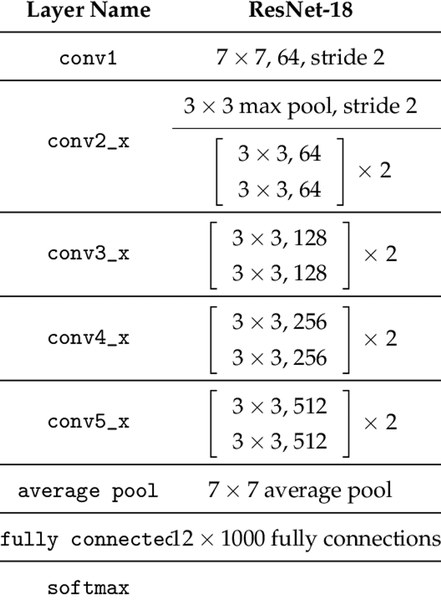

### üí° Í∏∞Î≥∏ Ï†úÍ≥µÎêú ResNet-18 Î™®Îç∏ÏóêÏÑú Î≥ÄÍ≤Ω/Ï∂îÍ∞ÄÎêú Ï†ê
- Output layer: Dense(1, activation='sigmoid')
    - softmax Í∞Ä ÏïÑÎãå sigmoid
        - Ïñ¥Ï∞®Ìîº ÌèêÎ†¥/Ï†ïÏÉÅÏù¥ÎØÄÎ°ú, Ïù¥ÏßÑ Î∂ÑÎ•ò Î¨∏Ï†úÏûÑ.
    - num_classes = 1
        - Ïù¥ÏßÑ Î∂ÑÎ•òÎãàÍπå.
- Dropout Ï∂îÍ∞Ä
    - ÏÑ∏Î∞ÄÌïú ÌäπÏßï ÌïôÏäµÏùÑ ÏúÑÌï¥, adamÏùò learning rateÎ•º 0.0005Î°ú Ï§ÑÏòÄÏùå.
    - ÏùºÎ∞òÏ†ÅÏúºÎ°ú Global Average Pooling ÌõÑ Fully Connected layer Î∞îÎ°ú ÏïûÏóê Ï†ÅÏö©ÌïòÎäî Í≤ÉÏù¥ Ìö®Í≥ºÏ†ÅÏù¥ÎØÄÎ°ú, Ìï¥Îãπ ÏúÑÏπòÏóê Íµ¨ÌòÑ.
    - 50% ÌôïÎ•†Î°úÎßå Ï†ÅÏö©ÌñàÏùå. learning rateÎ•º Î∞òÏ†àÎ°ú Ï§ÑÏòÄÍ∏∞ ÎïåÎ¨∏. Îã®, Ïù¥Í≤å Îî± Îñ®Ïñ¥ÏßÄÎäî ÎπÑÏú® ÏÑ§Ï†ïÏù∏ÏßÄÎäî ÏÇ¨Ïã§ ÌÖåÏä§Ìä∏ Ï†ÑÍπåÏßÄÎäî Î™®Î•¥Í≤†Ïùå.

In [149]:
def build_resnet18(input_shape, num_classes=1):
    inputs = tf.keras.Input(shape=input_shape)

    # Initial convolution and max-pooling
    x = keras.layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    # Residual blocks
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    x = residual_block(x, 128)
    x = residual_block(x, 128)

    x = residual_block(x, 256)
    x = residual_block(x, 256)

    x = residual_block(x, 512)
    x = residual_block(x, 512)

    # Global Average Pooling + fully connected layer
    x = keras.layers.GlobalAveragePooling2D()(x)
    
    # Adam learning rateÎ•º 0.001 -> 0.0005Î°ú Î≥ÄÍ≤ΩÌï† ÏòàÏ†ï.
    # Í∑∏Îü¨ÎØÄÎ°ú, Í≥ºÏ†ÅÌï© Î∞©ÏßÄ ÌïÑÏöî.
    x = keras.layers.Dropout(0.5)(x)

    outputs = keras.layers.Dense(num_classes, activation='sigmoid')(x)

    # Î™®Îç∏ Íµ¨ÏÑ±
    model = keras.Model(inputs, outputs)

    return model


# Î™®Îç∏ ÏÉùÏÑ±
# model = build_resnet18(input_shape, num_classes=1)


with tf.device('/GPU:0'):
    model = build_resnet18(input_shape, num_classes=1)

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='binary_crossentropy',
        metrics=METRICS
    )

### ‚ö†Ô∏è train_ds ÎÇò val_dsÍ∞Ä build_resnet18 Ïùò inputÏúºÎ°ú Ïïà Îì§Ïñ¥Í∞ÄÎèÑ ÎêúÎã§!
- build_resnet18 Ìï®ÏàòÎäî Î™®Îç∏Ïùò Íµ¨Ï°∞Î•º Ï†ïÏùòÌïòÎäî Ìï®ÏàòÏûÑ. Ïù¥ Ìï®ÏàòÏóêÏÑúÎäî Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ ÏßÅÏ†ë Îã§Î£®ÏßÄ ÏïäÍ≥†, Î™®Îç∏Ïùò **ÏûÖÎ†• ÌÅ¨Í∏∞(input_shape)**ÏôÄ Ï∂úÎ†• ÌÅ¨Í∏∞(num_classes) Í∞ôÏùÄ Ï†ïÎ≥¥Îßå ÌïÑÏöîÌï®.
- Îç∞Ïù¥ÌÑ∞ÏÖã(Ï¶â, train_dsÏôÄ val_ds)ÏùÄ Î™®Îç∏ ÌïôÏäµ Îã®Í≥ÑÏóêÏÑú fit Ìï®ÏàòÎ°ú Ï†ÑÎã¨ÎèºÏïº Ìï®. build_resnet18ÏùÄ Í∑∏Ï†Ä ÎÑ§Ìä∏ÏõåÌÅ¨Ïùò Íµ¨Ï°∞Î•º Ï†ïÏùòÌï† ÎøêÏù¥Í≥†, Îç∞Ïù¥ÌÑ∞ÏÖãÍ≥ºÎäî Î≥ÑÍ∞úÏùò Í≥ºÏ†ïÏûÑ.

### üí° AdamÏùÑ Í∑∏ÎåÄÎ°ú ÏÇ¨Ïö©ÌïòÎäî Ïù¥Ïú†
- Adam = Îπ†Î•∏ ÏàòÎ†¥(RMSprop) + Ï†ÅÏùëÏ†Å ÌïôÏäµÎ•†(SGD with Momentum)
    - Í∑∏Îü¨ÎØÄÎ°ú, ÏùòÎ£å Îç∞Ïù¥ÌÑ∞ÏÖãÏóêÏÑú ÏïàÏ†ïÏ†ÅÏù∏ ÌïôÏäµ ÏÑ±Îä•ÏùÑ Ï†úÍ≥µÌïòÍ∏∞ Í∞ÄÏû• Ï¢ãÏùÄ Í∞ÄÏÑ±ÎπÑ ÏòµÌã∞ÎßàÏù¥Ï†ÄÏûÑ.
    - Îã®, Í≥ºÏ†ÅÌï© Ï£ºÏùò.
        - dropout(0.5) Ï†ÅÏö©ÌñàÏúºÎãà Ìï¥Í≤∞ ÏôÑÎ£å...? Ïûò Î™®Î•¥Í≤†Îã§.

### üí° Í∏∞Î≥∏ Ï†úÍ≥µÎêú ResNet-18 Î™®Îç∏ÏóêÏÑú Î≥ÄÍ≤Ω/Ï∂îÍ∞ÄÎêú Ï†ê
- learning rate: 0.001 -> 0.0005
    - ÎçîÏö± ÏÑ∏Î∞ÄÌïú ÌïôÏäµÏùÑ ÌïòÏó¨ Ï†ïÎãµÎ•†ÏùÑ ÎÜíÏù¥Í∏∞ ÏúÑÌï®.
    - Í≥ºÏ†ÅÌï© Î∞©ÏßÄÎ•º ÏúÑÌï¥ Íµ¨ÌòÑÌïú, 'Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï' Î∞è 'Dropout'Ïùò Ìö®Í≥ºÍ∞Ä Ï∂©Î∂ÑÌûà ÏûàÏùÑ Í≤ÉÏù¥ÎùºÍ≥† Í∞ÄÏ†ïÌñàÏùå.

In [150]:
# Î™®Îç∏ Íµ¨Ï°∞ ÌôïÏù∏
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d_211 (Conv2D)             (None, 90, 90, 64)   9472        input_21[0][0]                   
__________________________________________________________________________________________________
batch_normalization_236 (BatchN (None, 90, 90, 64)   256         conv2d_211[0][0]                 
__________________________________________________________________________________________________
re_lu_192 (ReLU)                (None, 90, 90, 64)   0           batch_normalization_236[0][0]    
___________________________________________________________________________________________

## Step 5. Îç∞Ïù¥ÌÑ∞ imbalance Ï≤òÎ¶¨
Ïã§Ïäµ ÏΩîÎìúÏóêÏÑú Îç∞Ïù¥ÌÑ∞Ïùò imbalance Î¨∏Ï†úÏóê ÎåÄÏ≤òÌïòÍ∏∞ ÏúÑÌï¥ Îç∞Ïù¥ÌÑ∞ ÎπÑÏú®Î°ú ÎÇòÎàÑÏñ¥ÏßÑ class_weightÎ•º ÏÑ§Ï†ïÌï¥ Ï£ºÏóàÏäµÎãàÎã§. ÎßåÏïΩ Ïù¥Îü¨Ìïú Ï≤òÎ¶¨Î•º ÏÉùÎûµÌïúÎã§Î©¥ Ïñ¥ÎñªÍ≤å Îê†ÍπåÏöî? Îòê recallÏùÑ Í∞ïÏ°∞ÌïòÍ∏∞ ÏúÑÌï¥ ÌèêÎ†¥ Îç∞Ïù¥ÌÑ∞Î•º Ïûò ÎßûÏ∂îÎäî Í≤ÉÏùÑ Îçî Í∞ïÌôîÌïòÎäî Ìö®Í≥ºÎ•º ÎßåÎì§Ïñ¥ÎÇº ÏàòÎäî ÏóÜÏùÑÍπåÏöî?



## Step 6. Î™®Îç∏ ÌõàÎ†®
loss Ìï®ÏàòÎ•º Î≥ÄÍ≤ΩÌïòÍ∏∞Îäî Ïñ¥Î†µÍ≤†ÏßÄÎßå, optimizerÎÇò learning rate Îì±Ïùò Î≥ÄÌôîÎ•º Í≥†Î†§Ìï¥Î≥º Ïàò ÏûàÏùÑ Í≤ÉÏûÖÎãàÎã§.



### üí° Í∏∞Î≥∏ Ï†úÍ≥µÎêú ResNet-18 Î™®Îç∏ÏóêÏÑú Î≥ÄÍ≤Ω/Ï∂îÍ∞ÄÎêú Ï†ê
- BATCH_SIZE = 32  # 16->32
- EPOCHS = 12  # 10->12

In [151]:
from tensorflow.keras.callbacks import EarlyStopping

# Ï°∞Í∏∞ Ï¢ÖÎ£å ÏÑ§Ï†ï (Í≤ÄÏ¶ù ÏÜêÏã§Ïù¥ 3Î≤à Ïó∞ÏÜçÏúºÎ°ú Í∞úÏÑ†ÎêòÏßÄ ÏïäÏúºÎ©¥ ÌïôÏäµ Ï§ëÎã®)
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Î™®Îç∏ ÌïôÏäµ
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[early_stopping]
    )

Epoch 1/12
130/130 [==============================] - 111s 773ms/step - loss: 0.2718 - accuracy: 0.8959 - precision: 0.9658 - recall: 0.8919 - val_loss: 4.2873 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 2/12
130/130 [==============================] - 100s 773ms/step - loss: 0.1759 - accuracy: 0.9351 - precision: 0.9783 - recall: 0.9334 - val_loss: 5.2407 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 3/12
130/130 [==============================] - 100s 769ms/step - loss: 0.1717 - accuracy: 0.9404 - precision: 0.9814 - recall: 0.9377 - val_loss: 1.9161 - val_accuracy: 0.7461 - val_precision: 0.7433 - val_recall: 1.0000
Epoch 4/12
130/130 [==============================] - 100s 772ms/step - loss: 0.1490 - accuracy: 0.9435 - precision: 0.9834 - recall: 0.9398 - val_loss: 3.6812 - val_accuracy: 0.7295 - val_precision: 0.7295 - val_recall: 1.0000
Epoch 5/12
130/130 [==============================] - 100s 769ms/step - loss: 0.1481 - a

## Step 7. Í≤∞Í≥º ÌôïÏù∏Í≥º ÏãúÍ∞ÅÌôî

ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞Î°ú ÌõàÎ†®Îêú Î™®Îç∏ÏùÑ ÌèâÍ∞ÄÌï¥ Î¥ÖÏãúÎã§. Ïö∞ÏÑ†ÏùÄ accuracyÎ•º Í≥†Î†§Ìï¥ÏïºÍ≤†ÏßÄÎßå ÏùòÎ£å ÏòÅÏÉÅ Î™®Îç∏Ïùò ÌäπÏÑ±ÏÉÅ recallÎèÑ Ï§ëÏöîÌï©ÎãàÎã§. ÌõàÎ†®Í≥ºÏ†ïÏùò history Í∑∏ÎûòÌîÑÎ•º ÏãúÍ∞ÅÌôîÌï¥ Î≥¥Í≥†, ÌïôÏäµ ÏßÑÌñâ ÏñëÏÉÅÏùÑ Î©¥Î∞ÄÌûà Î∂ÑÏÑùÌï¥ Î≥¥Îäî Í≤ÉÎèÑ ÏûäÏßÄ ÏïäÎèÑÎ°ù Ìï©ÏãúÎã§.

## ÏÉà Î™®Îç∏ ÏÑ±Ï†Å

39/39 [==============================] - 6s 133ms/step - loss: 5.7415 - accuracy: 0.3830 - precision: 1.0000 - recall: 0.0128
Loss: 5.7415080070495605,
Accuracy: 0.3830128312110901,
Precision: 1.0,
Recall: 0.012820512987673283


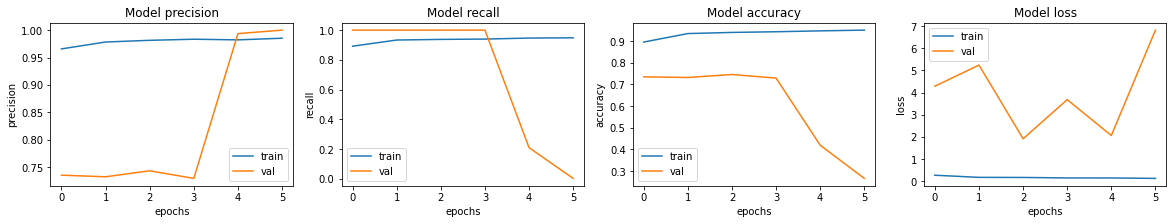

In [152]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

- Loss: 5.741
- Accuracy: 0.383
- Precision: 1.0
- Recall: 0.0128


## Í∏∞Ï°¥ Î™®Îç∏ ÏÑ±Ï†Å

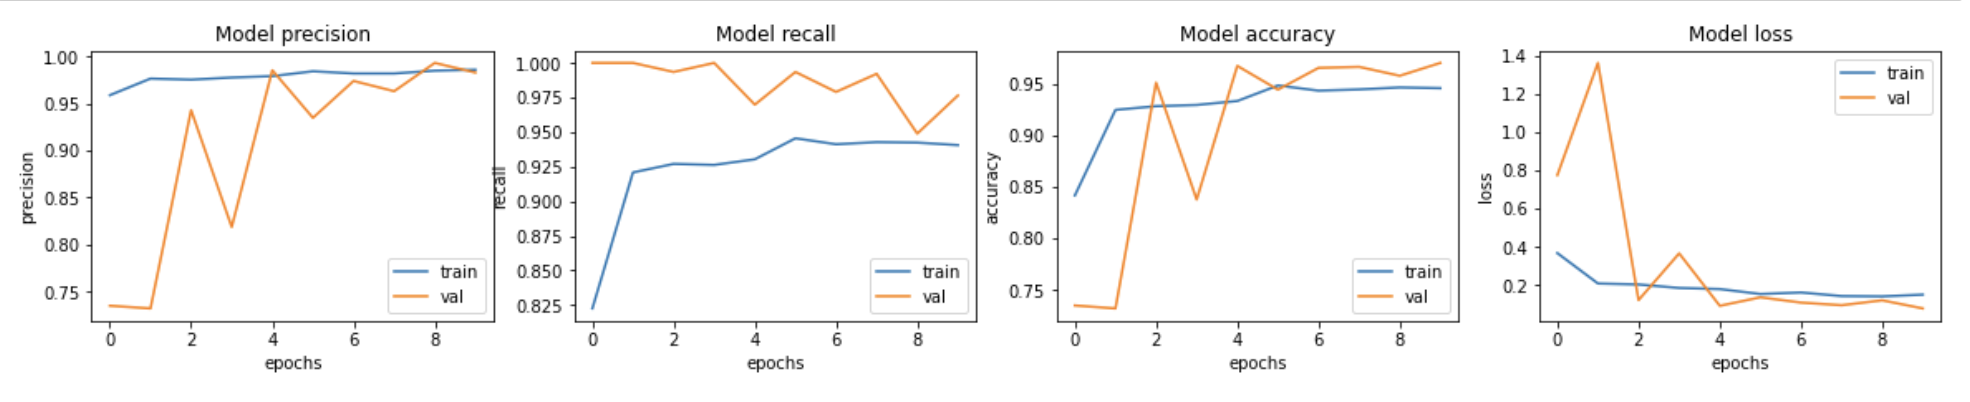

- Loss: 0.854
- Accuracy: 0.770
- Precision: 0.735
- Recall: 0.989

# Î≥¥Í≥†ÏÑú

## Ï±ÑÏ†ê Í∏∞Ï§Ä (Ï¥ù 5Ï†ê)
- ÌîÑÎ°úÏ†ùÌä∏ Ï†úÏ∂ú : 1Ï†ê
- Î£®Î∏åÎ¶≠ : 4Ï†ê
    - ÏùòÎ£åÏòÅÏÉÅÏùÑ Ï≤òÎ¶¨ÌïòÎäî CNN Í∏∞Î∞ò Î≤†Ïù¥Ïä§ Î™®Îç∏Ïù¥ Ïûò Íµ¨ÌòÑÎêòÏóàÎã§ 1Ï†ê
        - ÏïÑÎßà ÏôÑÎ£åÌïú ÎìØ...?
            - ÏÑ±Ï†ÅÏù¥ ÌÅ¨Í≤å Îã§Î•¥ÏßÄ ÏïäÏùÄ Í±∏ Î≥¥Î©¥.
    - Îç∞Ïù¥ÌÑ∞ augmentation Í∏∞Î≤ïÏùÑ ÏÇ¨Ïö©Ìï¥ÏÑú Î≤†Ïù¥Ïä§ Î™®Îç∏Í≥ºÏùò ÏÑ±Îä•ÏùÑ ÎπÑÍµê - 1Ï†ê
        - ÏôÑÎ£å.
            - Ï¶ùÍ∞ï Î∞è Dropout Ï†ÅÏö©Ìïú Î™®Îç∏Î°ú ÏÑ±Ï†Å ÎπÑÍµê.
    - Î™®Îç∏ Íµ¨Ï°∞ Î≥ÄÍ≤ΩÏùÑ ÌÜµÌï¥ Î≤†Ïù¥Ïä§ Î™®Îç∏Í≥ºÏùò ÏÑ±Îä• ÎπÑÍµê - 1Ï†ê
        - ÏôÑÎ£å.
            - Ï†ïÌôïÎèÑ Ìñ•ÏÉÅ Î∞è ÏµúÏ†ÅÌôî Îì±ÏùÑ ÏúÑÌï¥ ÎßéÏù¥ ÎÖ∏Î†•ÌñàÏùå.
    - ResNet-18 Î™®Îç∏ÏùÑ Íµ¨ÌòÑÌïòÍ≥† ÌïôÏäµ ÏÑ±Í≥µ - 1Ï†ê
        - Í∞úÏ°∞Îêú ResNet-18 Î™®Îç∏Ïù¥Í∏¥ ÌïòÏßÄÎßå... ÌïôÏäµÏùÄ ÏÑ±Í≥µ.
            - Î¨ºÎ°†, ÌõåÎ•≠Ìïú ÌïôÏäµÏù¥ÏóàÎäîÍ∞ÄÎäî Î≥ÑÍ∞úÎ°ú „Öé„Öé


---
## Summary

‚ö†Ô∏è Í≤ÄÏ¶ù ÏÜêÏã§Ïù¥ 3Î≤à Ïó∞ÏÜçÏúºÎ°ú Í∞úÏÑ†ÎêòÏßÄ ÏïäÏïÑÏÑú, ÌïôÏäµÏù¥ Ï§ëÎã®ÎêòÏóàÎã§. üò≠

### 1. **ÏÑ±Îä• ÎπÑÍµê**  
| **Metric**             | **Before**     | **After**      |
|------------------------|----------------|----------------|
| **Loss**               | 0.8542         | 5.7415         |
| **Accuracy**           | 0.7708         | 0.3830         |
| **Precision**          | 0.7352         | 1.0000         |
| **Recall**             | 0.9897         | 0.0128         |

---

### 2. **Î¨∏Ï†ú Î∂ÑÏÑù**
- **Loss Ï¶ùÍ∞Ä**: After Í≤∞Í≥ºÏóêÏÑú LossÍ∞Ä ÌÅ¨Í≤å Ï¶ùÍ∞ÄÌïú Í≤ÉÏùÄ Î™®Îç∏Ïù¥ ÌïôÏäµÏùÑ Ï†úÎåÄÎ°ú ÏàòÌñâÌïòÏßÄ Î™ªÌïú Í≤ÉÏúºÎ°ú Ìï¥ÏÑùÎêúÎã§.
- **Accuracy Í∞êÏÜå**: AccuracyÎäî 77.08%ÏóêÏÑú 38.30%Î°ú ÌïòÎùΩÌñàÏúºÎ©∞, Ïù¥Îäî Î™®Îç∏Ïù¥ Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞Ïóê ÎåÄÌïú ÏòàÏ∏° ÏÑ±Îä•Ïù¥ ÌÅ¨Í≤å Îñ®Ïñ¥Ï°åÏùåÏùÑ ÏùòÎØ∏ÌïúÎã§.
- **Precision 100% & Recall 1.28%**: PrecisionÏù¥ 100%Î°ú ÎÇòÏò® Í≤ÉÏùÄ Î™®Îì† ÏñëÏÑ± ÏòàÏ∏°Ïù¥ Ï†ïÌôïÌñàÏùåÏùÑ ÎÇòÌÉÄÎÇ¥ÏßÄÎßå, RecallÏù¥ Îß§Ïö∞ ÎÇÆÎã§Îäî Í≤ÉÏùÄ Î™®Îç∏Ïù¥ ÎåÄÎ∂ÄÎ∂ÑÏùò ÏñëÏÑ± Îç∞Ïù¥ÌÑ∞Î•º ÏòàÏ∏°ÌïòÏßÄ Î™ªÌïòÍ≥† ÏûàÏùåÏùÑ ÏãúÏÇ¨ÌïúÎã§. Ïù¥Îäî **Î∂àÍ∑†ÌòïÌïú ÏòàÏ∏°**Ïù¥ Î∞úÏÉùÌñàÏùåÏùÑ ÏùòÎØ∏ÌïúÎã§.

---

### 3. **Í∞úÏÑ† Î∞©Ïïà by GPT**
1. **ÌïôÏäµÎ•†(Learning Rate) Ï°∞Ï†ï**  
   ÌòÑÏû¨ ÏÑ§Ï†ïÎêú Learning Rate(0.0005)Î•º **0.001**Î°ú Ï¶ùÍ∞ÄÏãúÏºú, Î™®Îç∏Ïù¥ Ï†ÅÏ†àÌïòÍ≤å Í∞ÄÏ§ëÏπòÎ•º ÏóÖÎç∞Ïù¥Ìä∏Ìï† Ïàò ÏûàÎèÑÎ°ù Ï°∞Ï†ïÌïúÎã§. ÎÑàÎ¨¥ ÎÇÆÏùÄ ÌïôÏäµÎ•†ÏùÄ ÌïôÏäµÏùÑ Ï†ÄÌï¥Ìï† Ïàò ÏûàÎã§.
    - Í∑∏ÎÉ• 0.001Î°ú ÎÜîÎëò Í±∏...

2. **Í≥ºÏ†ÅÌï© Î∞©ÏßÄ Í∏∞Î≤ï Ï†ÅÏö©**  
   - **Dropout**: Í≥ºÏ†ÅÌï©ÏùÑ Î∞©ÏßÄÌïòÍ∏∞ ÏúÑÌï¥ DropoutÏùÑ Ï∂îÍ∞ÄÌïúÎã§. ÏòàÎ•º Îì§Ïñ¥, Global Average Pooling ÌõÑÏóê 50%Ïùò DropoutÏùÑ Ï†ÅÏö©ÌïòÏó¨ ÌïôÏäµ Ïãú ÏùºÎ∂Ä Îâ¥Îü∞ÏùÑ Î¨¥ÏûëÏúÑÎ°ú ÎπÑÌôúÏÑ±ÌôîÌï®ÏúºÎ°úÏç® Î™®Îç∏Ïù¥ Îç∞Ïù¥ÌÑ∞Ïóê Í≥ºÎèÑÌïòÍ≤å ÏùòÏ°¥ÌïòÏßÄ ÏïäÎèÑÎ°ù ÌïúÎã§.
       - Ïù¥ÎØ∏ ÏÇ¨Ïö©ÌñàÏßÄÎßå...
   - **Regularization**: Í∞ÄÏ§ëÏπòÏóê Ï†ïÍ∑úÌôîÎ•º Ï†ÅÏö©ÌïòÏó¨ Î™®Îç∏ Î≥µÏû°ÎèÑÎ•º ÎÇÆÏ∂îÍ≥† Í≥ºÏ†ÅÌï©ÏùÑ Î∞©ÏßÄÌïúÎã§.

3. **Class Weights Ï†ÅÏö©**  
   RecallÏù¥ ÎÇÆÏùÄ Ïù¥Ïú†Îäî Îç∞Ïù¥ÌÑ∞ Î∂àÍ∑†Ìòï Î¨∏Ï†úÏùº Ïàò ÏûàÎã§. ÏñëÏÑ± ÌÅ¥ÎûòÏä§(1)Ïóê Í∞ÄÏ§ëÏπòÎ•º Î∂ÄÏó¨ÌïòÏó¨ Î™®Îç∏Ïù¥ Î∂àÍ∑†Ìòï Îç∞Ïù¥ÌÑ∞Ïóê ÎåÄÌï¥ Îçî Ïûò ÌïôÏäµÌï† Ïàò ÏûàÎèÑÎ°ù Ï°∞Ï†ïÌïúÎã§.
    - Í∏∞Î≥∏ Ï†úÍ≥µ Í∞íÏúºÎ°úÎäî Î∂ÄÏ°±ÌñàÎçò Í±∏Íπå?

4. **Early Stopping**  
   Early StoppingÏùÑ ÎèÑÏûÖÌïòÏó¨ Í≤ÄÏ¶ù ÏÑ±Îä•Ïù¥ Ìñ•ÏÉÅÎêòÏßÄ ÏïäÏùÑ Îïå ÌïôÏäµÏùÑ Ï°∞Í∏∞Ïóê Ï¢ÖÎ£åÌïúÎã§. Ïù¥Î•º ÌÜµÌï¥ Î∂àÌïÑÏöîÌïú Í≥ºÏ†ÅÌï©ÏùÑ Î∞©ÏßÄÌï† Ïàò ÏûàÎã§.
    - ÎçïÎ∂ÑÏóê ÏãúÍ∞Ñ ÎÇ≠ÎπÑÎ•º ÎçúÏóàÎã§.

5. **Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï Í∞ïÌôî**  
   Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï Í∏∞Î≤ïÏùÑ Í∞ïÌôîÌïòÏó¨ ÌïôÏäµ Îç∞Ïù¥ÌÑ∞Ïùò Îã§ÏñëÏÑ±ÏùÑ ÎÜíÏù∏Îã§. ÎûúÎç§ ÌöåÏ†Ñ, Î∞ùÍ∏∞ Ï°∞Ï†ï, Ï¢åÏö∞ Î∞òÏ†Ñ Îì±ÏùÑ Ï∂îÍ∞ÄÌïòÏó¨ Í≥ºÏ†ÅÌï©ÏùÑ Î∞©ÏßÄÌïòÍ≥† ÏùºÎ∞òÌôî ÏÑ±Îä•ÏùÑ Ìñ•ÏÉÅÏãúÌÇ¨ Ïàò ÏûàÎã§.
    - Ìï¥Î¥§ÎäîÎç∞.. ÏûòÎ™ª ÌñàÎÇò?

---

### 4. **Í≤∞Î°†**
Î™®Îç∏Ïùò ÏÑ±Îä• Ï†ÄÌïòÎäî Í≥ºÏ†ÅÌï© Î∞è Îç∞Ïù¥ÌÑ∞ Î∂àÍ∑†ÌòïÏùò Í∞ÄÎä•ÏÑ±ÏùÑ ÏãúÏÇ¨ÌïúÎã§. Ïù¥Î•º Ìï¥Í≤∞ÌïòÍ∏∞ ÏúÑÌï¥ÏÑúÎäî ÌïôÏäµÎ•† Ï°∞Ï†ï, Í≥ºÏ†ÅÌï© Î∞©ÏßÄ Í∏∞Î≤ï Ï†ÅÏö©, Class Weights ÏÑ§Ï†ï, Í∑∏Î¶¨Í≥† Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ïÏùÑ ÌÜµÌïú ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ Îã§ÏñëÏÑ± ÌôïÎ≥¥Í∞Ä ÌïÑÏöîÌïòÎã§.

---
## ÌöåÍ≥†
- ÏΩîÎìú Íµ¨ÌòÑÏùÑ ÏßÅÏ†ë Ìï¥Î≥∏ Í≤ΩÌóòÏù¥ ÎÑàÎ¨¥ Ï†ÅÎã§ Î≥¥Îãà, Ïù¥ÎØ∏ Ï†úÍ≥µÎêú ÏΩîÎìúÎ•º ÌïÑÏöîÏóê ÎßûÍ≤å ÎúØÏñ¥Í≥†ÏπòÎäî Í≤ÉÎèÑ ÎÑàÎ¨¥ ÌûòÎì§ÏóàÎã§. GPT ÏùòÏ°¥ÎèÑÍ∞Ä Í±∞Ïùò 70% Ïù¥ÏÉÅÏù¥ÏóàÎçò Í≤É Í∞ôÎã§.
    - Í∑∏ÎûòÎèÑ Îã§ÌñâÏù∏ Í≤ÉÏùÄ, Í≥ÑÏÜç ÏΩîÎìúÎ•º Î≥¥Îã§ Î≥¥Îãà Ïñ¥Îäê Ï†ïÎèÑ Íµ¨Ï°∞Í∞Ä ÏùµÏàôÌï¥Ï†∏ÏÑú, GPTÍ∞Ä ÏûêÍæ∏Îßå ÎÜìÏπòÎäî Î∂ÄÎ∂ÑÏùÑ ÎÇ¥Í∞Ä Ïñ¥ÎäêÏ†ïÎèÑ ÏßÄÏ†ÅÌï† Ïàò ÏûàÍ≤å ÎêòÏóàÎã§Îäî Ï†êÏù¥Îã§.

- Îã§ÏùåÎ∂ÄÌÑ∞Îäî ÏùºÎã® ÏÉàÎ°ú ÎßåÎì† Î™®Îç∏Ïù¥ Ï†ïÏÉÅÏ†ÅÏúºÎ°ú ÏûëÎèôÎêòÎäîÏßÄÎ∂ÄÌÑ∞ Î®ºÏ†Ä ÌÖåÏä§Ìä∏ Ìï¥Î≥¥Í≥†, Ïù¥ÌõÑÏóê ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞Î•º Ï°∞Ï†ïÌïòÎì† ÎßêÎì† Ìï¥ÏïºÍ≤†Îã§. ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞Î•º Ïñ¥ÎñªÍ≤å Ï°∞Ï†àÌïòÎ©¥ Ï¢ãÏùÑÏßÄ Í≥ÑÏÜç GPT Î∞è Íµ¨Í∏ÄÍ≥º Ïî®Î¶ÑÌïòÎã§ Î≥¥Îãà, ÏãúÍ∞ÑÏù¥ Îã§ Í∞ÄÎ≤ÑÎ†∏Îã§.

- ÏãúÍ∞ÑÏù¥ ÎçîÏö± Ï∂©Î∂ÑÌñàÎã§Î©¥,
    - Îã§ÏñëÌïú Î∞©ÏãùÏúºÎ°ú Ïã§ÌóòÌï¥Î≥¥ÏïòÏùÑÌÖêÎç∞...
        - ÎÇ¥Í∞Ä Íµ¨Ï∂ïÌïú ÏÉàÎ°úÏö¥ Î™®Îç∏ÏùÄ Îëê Î≤àÎ∞ñÏóê ÎèåÎ†§Î≥¥ÏßÄ Î™ªÌñàÎã§. Í≥ÑÏÜç ÏèüÏïÑÏ†∏ÎÇòÏò§Îäî ÏàòÎßéÏùÄ Ïò§Î•òÎì§ÏùÑ Í≥†ÏπòÎ©¥ÏÑú Î™®Îç∏ Íµ¨ÌòÑÌïòÎäêÎùº Ïó¨Ïú† ÏãúÍ∞ÑÏùÑ Ï†ÑÎ∂Ä ÏÜåÎ™®Ìï¥Î≤ÑÎ¶∞ Í≤å ÎÑàÎ¨¥ ÏïÑÏâΩÎã§.
    - Î™®Îç∏ÏùÑ Ï†úÎåÄÎ°ú Íµ¨ÌòÑÌñàÏùÑÌÖêÎç∞...
        - Í≤∞Íµ≠ Î™®Îç∏ÏùÑ ÏôÑÏ†ÑÌûà ÏûòÎ™ª Íµ¨ÌòÑÌïòÏó¨, ÏµúÏïÖÏùò ÏÑ±Ï†ÅÏùÑ Î∞õÏïÑÎ≤ÑÎ†∏Îã§. 50% Î≥¥Îã§ ÎÇÆÏùÄ Ï†ïÌôïÎèÑÎùºÎãà„Öã„Öã„Öã Ïù¥Îü∞...
        - Î™®Îç∏ÏùÑ Ìïú Î≤à Îçî ÎèåÎ†§Î≥º ÏãúÍ∞ÑÏ°∞Ï∞®ÎèÑ Î∂ÄÏ°±ÌïòÏó¨, Ïñ¥ÎîîÏÑúÎ∂ÄÌÑ∞ Ïñ¥ÎñªÍ≤å ÏûòÎ™ªÎêú Í±¥ÏßÄ ÏïåÏïÑÎ≥º ÏàòÎèÑ ÏóÜÏù¥ ÎãπÏû• Ï†úÏ∂úÌï¥ÏïºÌïòÎäî Ïù¥ ÏÉÅÌô©Ïù¥ Ï∞∏ Í≥†ÌÜµÏä§ÎüΩÎã§.

- Ïó¨ÌÉúÍπåÏßÄÎäî LMSÎ•º ÌÜµÌï¥ 'ÎπàÏπ∏ Ï±ÑÏö∞Í∏∞'Îßå Ìï¥ÏôîÍ∏∞ ÎïåÎ¨∏Ïóê 'Îú¨Íµ¨Î¶Ñ Ïû°Îäî ÎäêÎÇå'Ïù¥ Í∞ïÌñàÏßÄÎßå, Ïù¥Î≤àÏóê GPTÏùò ÎèÑÏõÄÏùÄ Î∞õÏïòÏùÑÏßÄÏñ∏Ï†ï ÏßÅÏ†ë Ïò®Í∞ñ ÏΩîÎìúÎ•º ÏîπÍ≥† ÎúØÍ≥† ÎßõÎ≥¥Í≥† Ï¶êÍ≤®Î≥∏ ÎçïÎ∂ÑÏóê, Ìú¥Ïùº Ïó¨Í∞ÄÏãúÍ∞ÑÏùÑ ÌôúÏö©ÌïòÏó¨ ÎÖ∏Îìú ÎÇ¥Ïö©ÏùÑ Î≥µÏäµÌïòÎ©¥ Ï∂©Î∂ÑÌûà ÌòºÏûêÏÑúÎèÑ Î™®Îç∏ÏùÑ ÌïôÏäµÏãúÏºúÎ≥º Ïàò ÏûàÏùÑ Í≤É Í∞ôÎã§Îäî ÏûêÏã†Í∞êÏù¥ ÏÉùÍ≤ºÎã§. Î¨ºÎ°†, Í∑ºÍ±∞Îäî ÏóÜÎã§.


---
## Reference
- LMS Í∏∞Î≥∏ Ï†úÍ≥µ ÏΩîÎìú
- GPT-4o